In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Fantasy Premier League (FPL) Player Data Breakdown

### 1. Player Availability & Status
- **chance\_of\_playing\_next\_round**: Probability (percentage) that the player will play in the next round (gameweek).
- **chance\_of\_playing\_this\_round**: Probability (percentage) that the player will play in the current round.
- **status**: Player’s current status, where `a` means available, `i` means injured, `d` means doubtful, etc.
- **news**: Relevant news about the player (e.g., injuries).
- **news\_added**: Timestamp indicating when the player's news was last updated.

### 2. Player Identification
- **id**: Unique identifier for the player within the FPL system.
- **code**: Another internal player identifier used by FPL.
- **first\_name**: Player’s first name.
- **second\_name**: Player’s last name.
- **web\_name**: The name displayed on FPL, typically a simplified form, e.g., G. Jesus.
- **team**: The ID of the Premier League team the player belongs to.
- **team\_code**: Alternative code for the player’s team (linked to `team`).
- **element\_type**: The player’s position:
  - 1: Goalkeeper
  - 2: Defender
  - 3: Midfielder
  - 4: Forward

### 3. Player Price & Transfers
- **now\_cost**: Player’s current price in FPL (multiplied by 10). For example, 68 means £6.8m.
- **cost\_change\_start**: Change in player’s price since the start of the season.
- **cost\_change\_start\_fall**: Total decrease in price since the start of the season.
- **cost\_change\_event**: Change in price in the current gameweek.
- **cost\_change\_event\_fall**: Decrease in price in the current gameweek.
- **transfers\_in**: Total number of transfers in for this player during the season.
- **transfers\_in\_event**: Transfers in during the current gameweek.
- **transfers\_out**: Total number of transfers out during the season.
- **transfers\_out\_event**: Transfers out in the current gameweek.

### 4. Performance in Current Season
- **total\_points**: Total points the player has accumulated this season.
- **points\_per\_game**: Average points scored per game played.
- **form**: Player’s recent form over the last 30 days.
- **ep\_next**: Expected points in the next round.
- **ep\_this**: Expected points in the current round.
- **value\_form**: Value metric combining form and price (form per £m).
- **value\_season**: Player’s season value based on points per £m.
- **event\_points**: Points scored in the most recent gameweek.

### 5. Player Game Statistics
- **minutes**: Total minutes played.
- **goals\_scored**: Total number of goals scored.
- **assists**: Total number of assists provided.
- **clean\_sheets**: Total clean sheets (mainly for defenders and goalkeepers).
- **goals\_conceded**: Goals conceded (defenders and goalkeepers).
- **own\_goals**: Own goals scored.
- **penalties\_saved**: Penalties saved (for goalkeepers).
- **penalties\_missed**: Penalties missed.
- **yellow\_cards**: Total yellow cards received.
- **red\_cards**: Total red cards received.
- **saves**: Total number of saves (for goalkeepers).
- **bonus**: Bonus points earned.
- **bps**: Bonus Points System score used for calculating bonus points.

### 6. Influence, Creativity, Threat, and ICT Index
These metrics come from FPL’s proprietary system to quantify player contributions:

- **influence**: Measures player’s impact on the game (e.g., goals, assists, key passes).
- **creativity**: Player’s ability to create goal-scoring opportunities (e.g., key passes).
- **threat**: Player’s likelihood of scoring goals (e.g., shots taken).
- **ict\_index**: Combines Influence, Creativity, and Threat into one metric.

### 7. Gameweek Performance Statistics
- **starts**: Number of games started.
- **expected\_goals**: Expected goals based on chances.
- **expected\_assists**: Expected assists based on chances created.
- **expected\_goal\_involvements**: Expected goals + assists.
- **expected\_goals\_conceded**: Expected goals conceded.

### 8. Per 90 Metrics
These metrics scale player stats to per-90-minute intervals:

- **expected\_goals\_per\_90**: Expected goals per 90 minutes.
- **expected\_assists\_per\_90**: Expected assists per 90 minutes.
- **expected\_goal\_involvements\_per\_90**: Expected goal involvements per 90 minutes.
- **expected\_goals\_conceded\_per\_90**: Expected goals conceded per 90 minutes.
- **goals\_conceded\_per\_90**: Goals conceded per 90 minutes.
- **saves\_per\_90**: Saves per 90 minutes (for goalkeepers).
- **starts\_per\_90**: Starts per 90 minutes.

### 9. Rankings
Rankings compare the player to others in similar positions or across the entire league:

- **influence\_rank**: Overall influence rank among all players.
- **influence\_rank\_type**: Influence rank among players in the same position.
- **creativity\_rank**: Overall creativity rank among all players.
- **creativity\_rank\_type**: Creativity rank among players in the same position.
- **threat\_rank**: Overall threat rank.
- **threat\_rank\_type**: Threat rank among players in the same position.
- **ict\_index\_rank**: Overall ICT Index rank.
- **ict\_index\_rank\_type**: ICT Index rank among players in the same position.
- **now\_cost\_rank**: Rank based on player’s price compared to all players.
- **now\_cost\_rank\_type**: Cost rank among players in the same position.
- **form\_rank**: Form rank compared to all players.
- **form\_rank\_type**: Form rank among players in the same position.
- **points\_per\_game\_rank**: Rank based on points per game.
- **points\_per\_game\_rank\_type**: Points per game rank among players in the same position.
- **selected\_rank**: Rank based on the percentage of managers who own the player.
- **selected\_rank\_type**: Rank among other players in the same position.

### 10. Set Piece Information
These fields relate to whether the player is involved in set-pieces (corners, free kicks, penalties):

- **corners\_and\_indirect\_freekicks\_order**: The player's order in taking corners and indirect free kicks.
- **corners\_and\_indirect\_freekicks\_text**: Notes on the player's role in taking set pieces.
- **direct\_freekicks\_order**: The player's order in taking direct free kicks.
- **direct\_freekicks\_text**: Notes on the player's role in taking direct free kicks.
- **penalties\_order**: The player's order in taking penalties.
- **penalties\_text**: Notes on the player's role in taking penalties.


# Load Data

Could move this to `combine_new_gameweek.py` script

In [2]:
# Define team mapping
team_mapping = {
    'Arsenal': 1,
    'Aston Villa': 2,
    'Bournemouth': 3,
    'Brentford': 4,
    'Brighton': 5,
    'Chelsea': 6,
    'Crystal Palace': 7,
    'Everton': 8,
    'Fulham': 9,
    'Ipswich': 10,
    'Leicester': 11,
    'Liverpool': 12,
    'Man City': 13,
    'Man Utd': 14,
    'Newcastle': 15,
    'Nott\'m Forest': 16,
    'Southampton': 17,
    'Spurs': 18,
    'West Ham': 19,
    'Wolves': 20,
    'Burnley': 21,
    'Luton': 22,
    'Sheffield Utd': 23,
    'Leeds': 24,
    'Watford': 25,
    'West Brom': 26,
    'Norwich': 27
}

In [3]:
# Define position mapping
pos_mapping = {'GK': 1,
              'GKP': 1,
              'DEF': 2,
              'MID': 3,
              'FWD': 4}

In [4]:
def one_hot_encode_team(team_id, num_teams=20):
    # Create a zero array of length num_teams
    one_hot = np.zeros(num_teams)
    
    # Set the correct index to 1 (team_id - 1 because team_id starts from 1)
    one_hot[team_id - 1] = 1
    
    return one_hot

In [5]:
# Load data
df_all = pd.read_csv('data/all_seasons_merged.csv')
df_all = df_all.fillna(0)

# Add team and position IDs, update names
df_all['team_id'] = df_all['team'].map(team_mapping)
df_all['opp_team_id'] = df_all['opponent_team'].map(team_mapping)
df_all['pos_id'] = df_all['position'].map(pos_mapping)

# Show
df_all.head()

,name,position,team,xP,assists_x,bonus,bps,clean_sheets,creativity,element,...,xGBuildup,player_id,expected_assists,expected_goal_involvements,expected_goals,expected_goals_conceded,starts,team_id,opp_team_id,pos_id
0,Aaron Connolly,FWD,Brighton,0.5,0,0,-3,0,0.3,78,...,0.000000,7991.0,0.0,0.0,0.0,0.0,0.0,5,6,4
1,Aaron Cresswell,DEF,West Ham,2.1,0,0,11,0,11.2,435,...,0.194548,534.0,0.0,0.0,0.0,0.0,0.0,19,15,2
2,Aaron Ramsdale,GK,Sheffield Utd,2.5,0,0,12,0,0.0,483,...,0.047631,5603.0,0.0,0.0,0.0,0.0,0.0,23,20,1
3,Abdoulaye Doucouré,MID,Everton,1.3,0,0,20,1,44.6,512,...,0.297199,1726.0,0.0,0.0,0.0,0.0,0.0,8,18,3
4,Aboubakar Kamara,MID,Fulham,0.4,0,0,-2,0,1.8,190,...,0.000000,4866.0,0.0,0.0,0.0,0.0,0.0,9,1,3


# Visualize Correlation Matrix of Data

In [7]:
# Assuming df_all is your dataframe
df_all['team_goals'] = df_all.apply(
    lambda row: row['team_h_score'] if row['was_home'] else row['team_a_score'], axis=1
)

df_all['opponent_goals'] = df_all.apply(
    lambda row: row['team_a_score'] if row['was_home'] else row['team_h_score'], axis=1
)

In [8]:
# numeric_df.starts

In [9]:
# numeric_df.columns

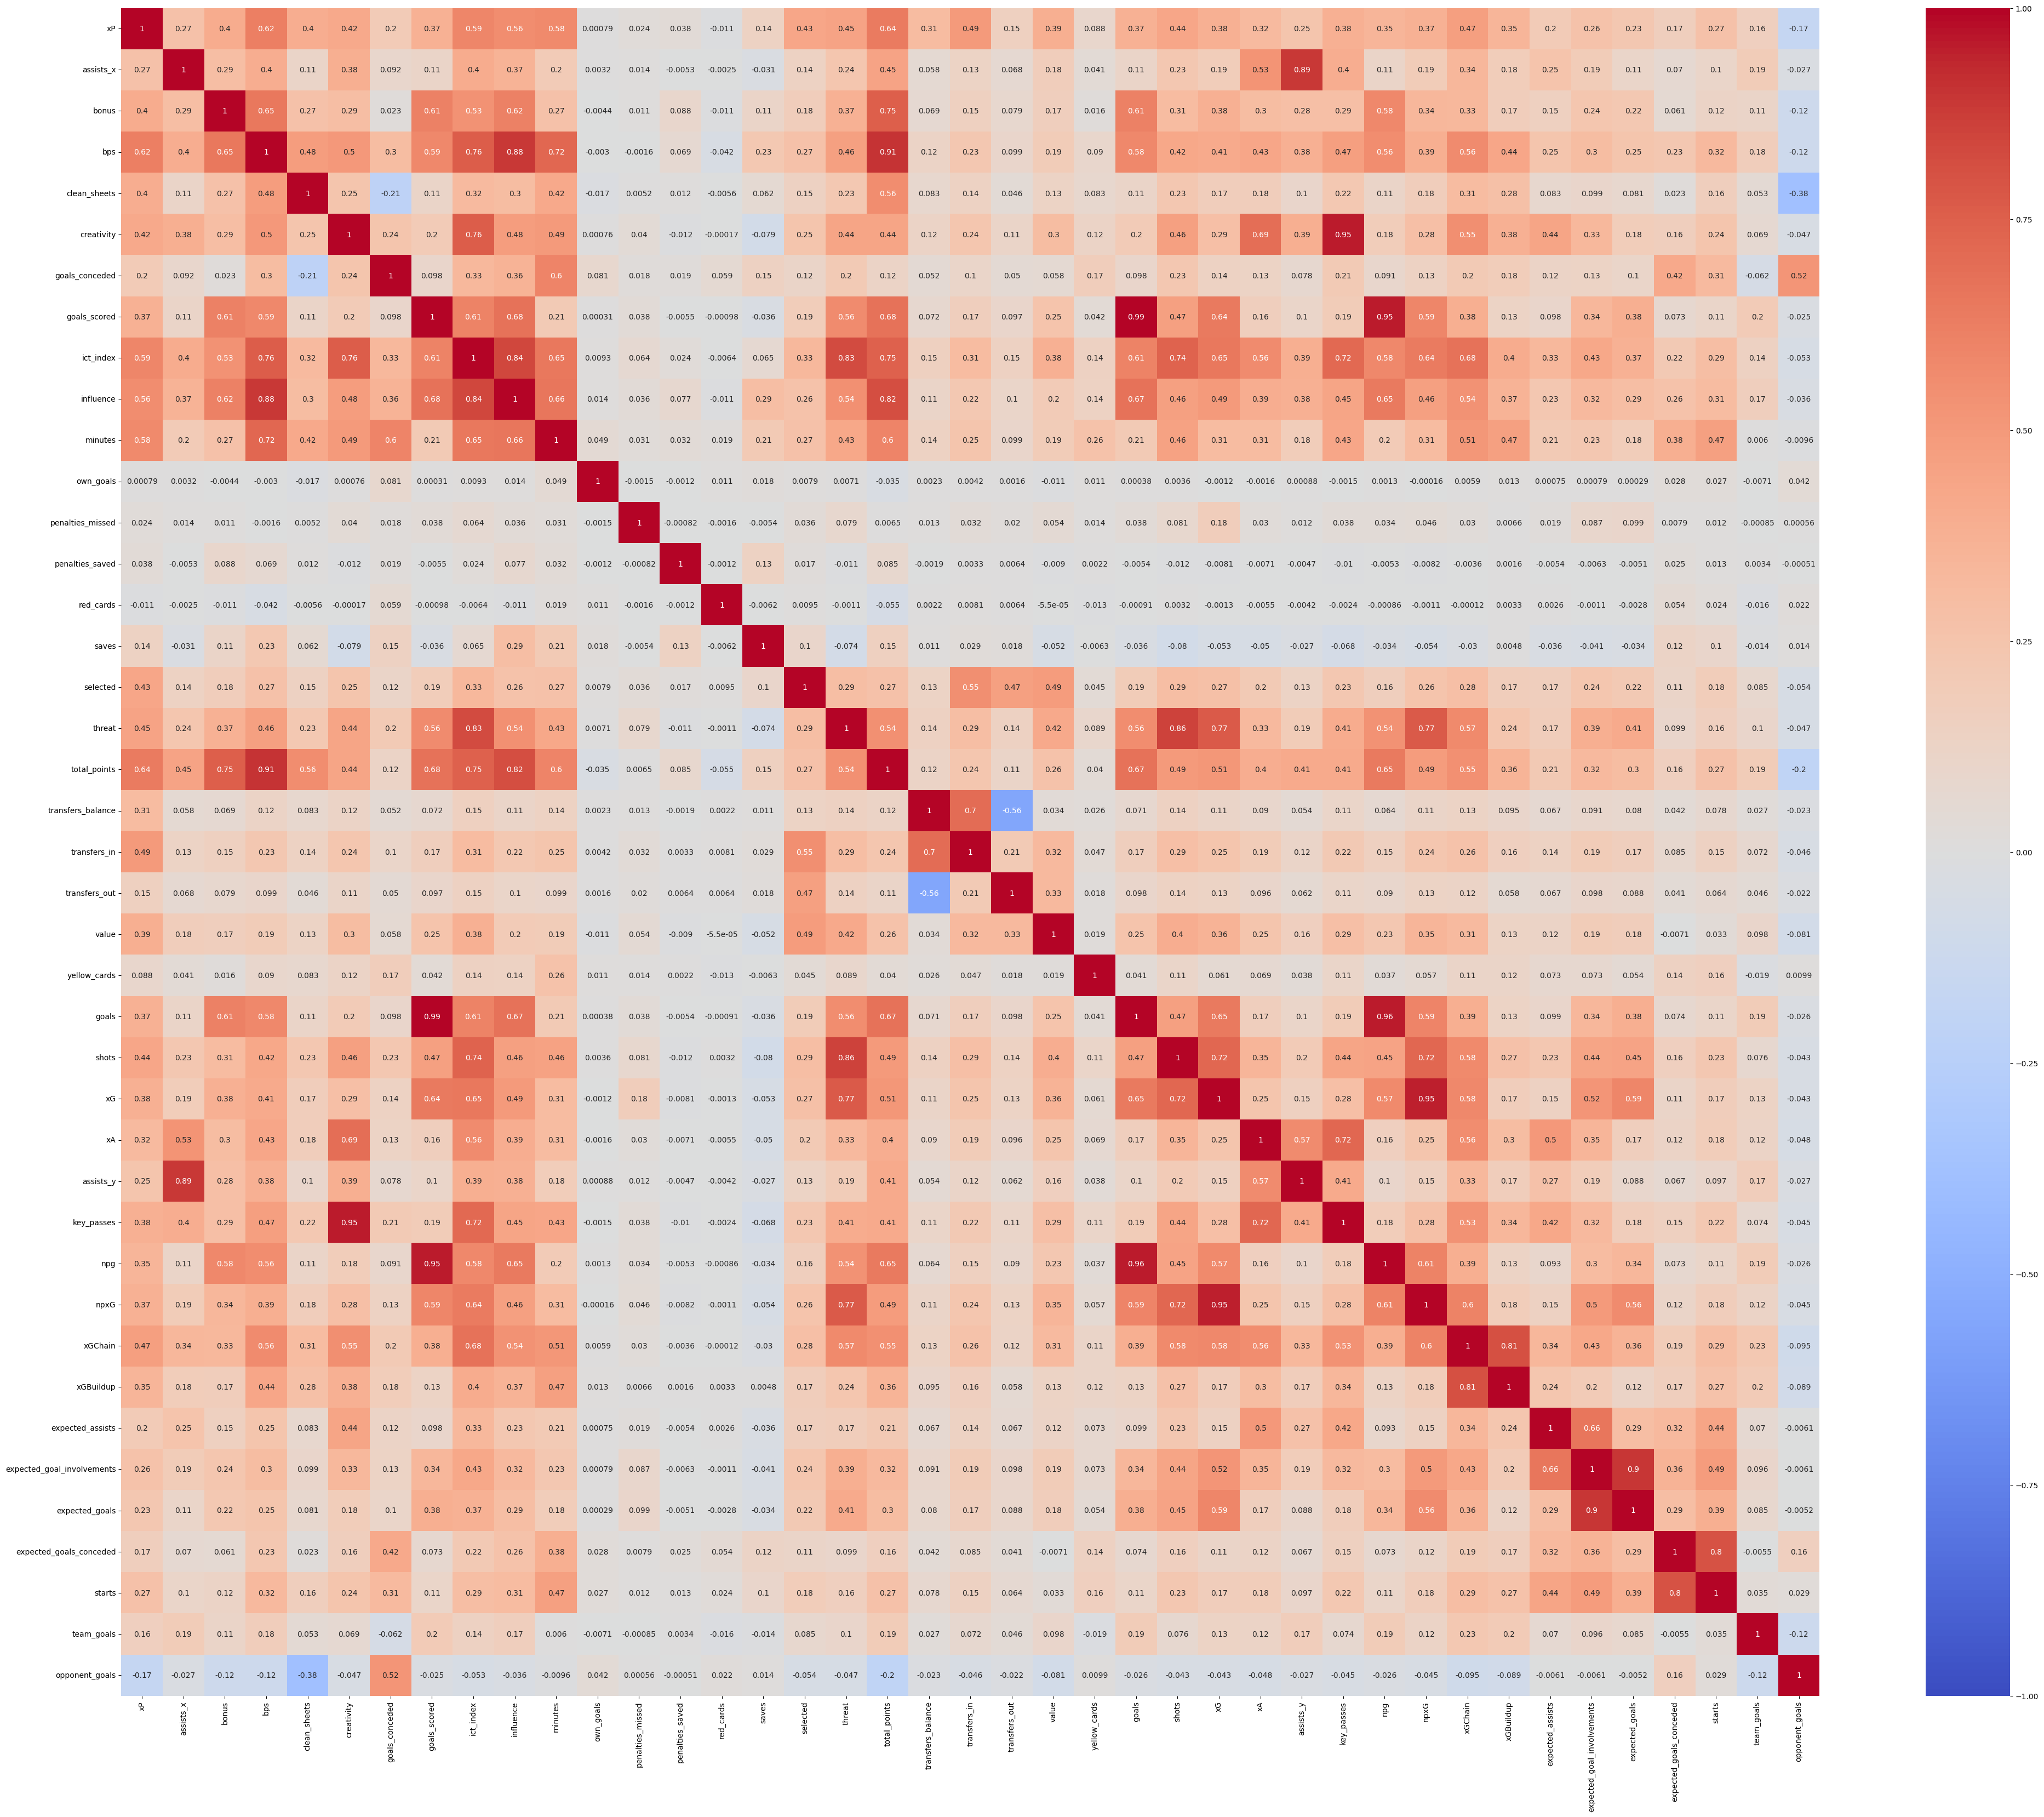

In [14]:
# Select only numeric columns
numeric_df = df_all.select_dtypes(include='number')

# List of columns to drop
columns_to_drop = [
    'element', 'fixture', 'round', 'GW', 'id',
    'season', 'roster_id', 'player_id', 'team_id', 'opp_team_id',
    'pos_id', 'time',
    
    'h_goals', 'a_goals', 'team_a_score', 'team_h_score',
    #, 'goals', 'expected_goal_involvements'
]

# Dropping the columns
numeric_df = numeric_df.drop(columns=columns_to_drop)

# All possible keys
keys_to_select = list(numeric_df.columns)

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Visualize Matrix
plt.figure(figsize=(50, 40))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.savefig('correlation_matrix_heatmap.png')
plt.show()

In [15]:
df_part = df_all[['name', 'kickoff_date', 'minutes', 'goals_scored', 'goals']]

In [16]:
g1 = list(df_all.goals_scored)
g2 = list(df_all.goals)

In [17]:
for i in range(len(g1)):
    if g1[i] != g2[i]:
        print(g1[i],g2[i])
        print(df_part.iloc[i])

1 0.0
name            Gabriel Magalhães
kickoff_date           2020-09-12
minutes                        90
goals_scored                    1
goals                         0.0
Name: 112, dtype: object
2 0.0
name            Aleksandar Mitrović
kickoff_date             2020-09-19
minutes                          90
goals_scored                      2
goals                           0.0
Name: 362, dtype: object
1 0.0
name            Bobby Decordova-Reid
kickoff_date              2020-09-19
minutes                           32
goals_scored                       1
goals                            0.0
Name: 407, dtype: object
2 0.0
name            Hélder Wander Sousa de Azevedo e Costa
kickoff_date                                2020-09-19
minutes                                             90
goals_scored                                         2
goals                                              0.0
Name: 513, dtype: object
1 0.0
name            Rodrigo Moreno
kickoff_date        2020-10-0

In [ ]:
df_part[df_part.name == 'Gabriel Magalhães']

In [ ]:
df_all[df_all.name == 'Gabriel Magalhães'].iloc[0][:20]

# Make Training Data

In [ ]:
keys_to_select = [
    # Overall
    'total_points',
    'minutes',
    'transfers_in',
    'transfers_out',

    # Attacking
    'goals_scored',
    'assists',
    'shots',
    'xG',
    'xA',
    'key_passes',
    'npg',
    'npxG',
    'xGChain',
    'xGBuildup',
    'expected_assists',
    'expected_goal_involvements',
    'expected_goals',
    
    # Defensive
    'clean_sheets',
    'goals_conceded',
    'saves',
    'penalties_saved',
    'expected_goals_conceded',
    'own_goals',
    
    # Cards
    'yellow_cards',
    'red_cards',
    
    # Penalties
    'penalties_missed',
    
    # Bonus and ICT
    'bonus',
    'bps',
    'threat',
    'influence',
    'creativity',
]

In [18]:
X = []
y = []
played = []

for player in df_all.name.unique():
    df_temp = df_all[df_all.name == player].copy()
    if len(df_temp) < 4:
        continue
    
    for i in range(3, len(df_temp)):
        
        # Select row for next game
        next_game = df_temp.iloc[i]
        
        if next_game['minutes']+df_temp.iloc[i-1]['minutes']+df_temp.iloc[i-2]['minutes']+df_temp.iloc[i-3]['minutes']==0:
            played.append(0)
        else:
            played.append(1)
        
        # Get one-hot encoding for players team, opp team, home/away and position
        player_team = one_hot_encode_team(next_game['team_id'], 27)
        opponent_team = one_hot_encode_team(next_game['opp_team_id'], 27)
        home_away = one_hot_encode_team(next_game['was_home'], 2)
        position = one_hot_encode_team(next_game['pos_id'], 4)
        
        # Combine into one vector
        combined_stats = np.concatenate([player_team, opponent_team, home_away, position])
        
        # Get points scored (y value)
        points = next_game['total_points']
        
        # Get player stats from previous games
        for j in range(1,4):
            row_temp = df_temp.iloc[i-j]
            
            # Get home/away encoding
            home_away = one_hot_encode_team(row_temp['was_home'], 2)
            
            # Add player team goals and opponent team goals
            if row_temp.was_home:
                score = np.array(row_temp[['team_h_score', 'team_a_score']].astype(float).values)
            else:
                score = np.array(row_temp[['team_a_score','team_h_score']].astype(float).values)
            
            # Select the wanted stats and convert to float numpy array
            selected_stats = np.array(row_temp[keys_to_select].astype(float).values) 
                
            # Combine into one vector
            combined_stats = np.concatenate([combined_stats, home_away, score, selected_stats])
            
        # Append combined stats to X and points (y value) to y
        X.append(combined_stats)
        y.append(points)
        
        
# Convert lists to numpy arrays for training/testing
X = np.array(X)
y = np.array(y)
played = np.array(played)

print("Training data (X):", X.shape)
print("Target values (y):", y.shape)
print("Played values (y):", played.shape)

Training data (X): (99297, 195)
Target values (y): (99297,)
Played values (y): (99297,)


# Train model - XGBoost

### Data split and scaler

In [120]:
# Split the data into training and testing sets
y_clipped = np.clip(y, 0, 12)
X_train, X_val, y_train, y_val, played_train, played_val = train_test_split(X,y_clipped,played,test_size=0.2,random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [91]:
# # Only select games where the player played within the last 3 games
# X_train_played = X_train[played_train==1]
# X_val_played = X_val[played_val==1]
# y_train_played = y_train[played_train==1]
# y_val_played = y_val[played_val==1]

# # Normalize the features
# scaler_played = StandardScaler()
# X_train_played = scaler_played.fit_transform(X_train_played)
# X_val_played = scaler_played.transform(X_val_played)

# # Train model
# model_played = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
# model_played.fit(X_train_played, y_train_played)

# # Predict and evaluate
# predictions = model_played.predict(X_val_played)
# mse_p = mean_squared_error(y_val_played, predictions)
# print(f'Mean Squared Error: {mse_p:.2f}')

### Train model

In [191]:
# train_mse = []
# valid_mse = []
# indices = []

# for i in range(1, 10):
#     # Train model
#     model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=i)
#     model.fit(X_train, y_train)

#     # Predictions train
#     predictions = model.predict(X_train)
#     mse_t = mean_squared_error(y_train, predictions)

#     # Predictions val
#     predictions = model.predict(X_val)
#     mse_v = mean_squared_error(y_val, predictions)
#     print(f'i={i}, MSE Train: {mse_t:.2f}, MSE Valid: {mse_v:.2f}')
    
#     train_mse.append(mse_t)
#     valid_mse.append(mse_v)
#     indices.append(i)
    
# plt.figure()
# plt.plot(indices, train_mse)
# plt.plot(indices, valid_mse)
# plt.show()

In [190]:
weights = np.where(y_train > 2, 2.5, 1.0)

# Train model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X_train, y_train, sample_weight=weights)

# Predict and evaluate
predictions = model.predict(X_val)
mse = mean_squared_error(y_val, predictions)
print(f'Mean Squared Error: {mse:.2f}')

Mean Squared Error: 4.79


### Show results - Training set

Mean Squared Error: 3.20


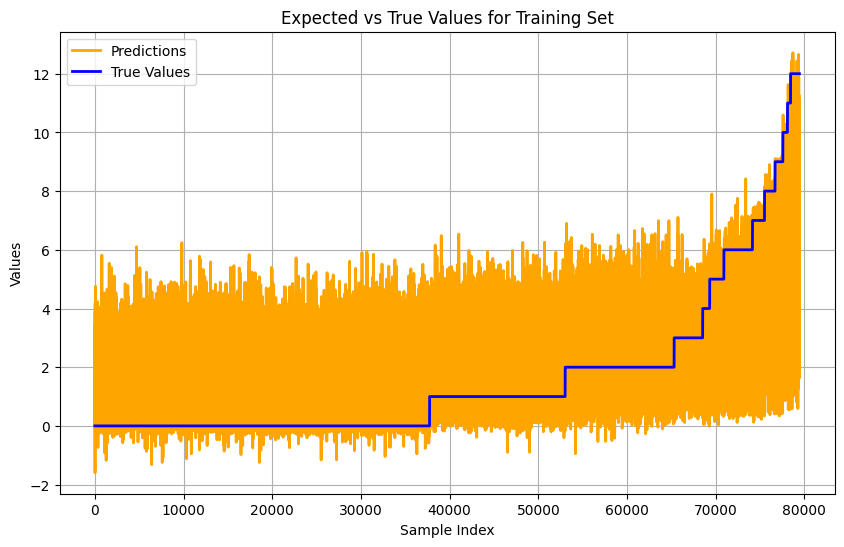

In [192]:
# Predict and evaluate
predictions = model.predict(X_train)
mse = mean_squared_error(y_train, predictions)
print(f'Mean Squared Error: {mse:.2f}')

# Sort values for a better line plot
sorted_indices = np.argsort(y_train)
sorted_y_train = y_train[sorted_indices]
sorted_predictions = predictions[sorted_indices]

# Plot expected values and true values
plt.figure(figsize=(10, 6))
plt.plot(sorted_predictions, label='Predictions', color='orange', linewidth=2)
plt.plot(sorted_y_train, label='True Values', color='blue', linewidth=2)
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.title('Expected vs True Values for Training Set')
plt.legend()
plt.grid(True)
plt.show()

### Show results - Validation set

Mean Squared Error: 4.79


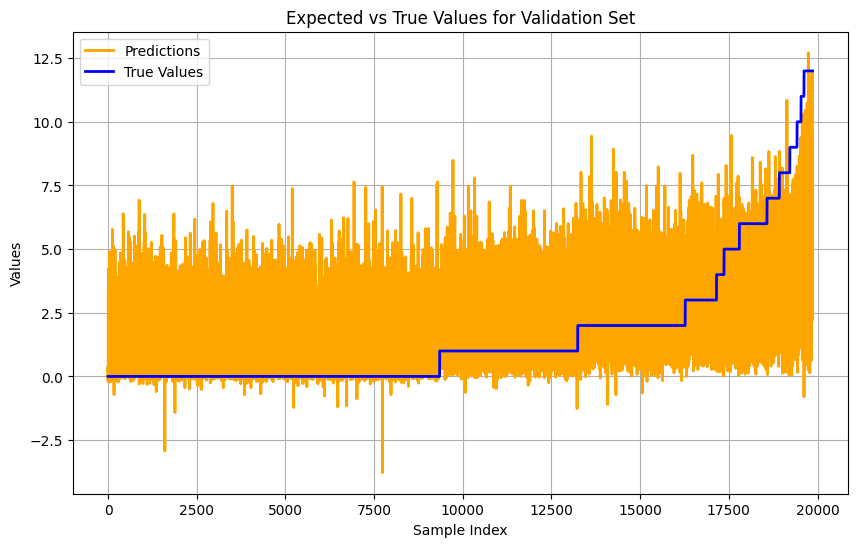

In [197]:
# Predict and evaluate
predictions = model.predict(X_val)
mse = mean_squared_error(y_val, predictions)
print(f'Mean Squared Error: {mse:.2f}')

# Sort values for a better line plot
sorted_indices = np.argsort(y_val)
sorted_y_val = y_val[sorted_indices]
sorted_predictions = predictions[sorted_indices]

# Plot expected values and true values
plt.figure(figsize=(10, 6))
plt.plot(sorted_predictions, label='Predictions', color='orange', linewidth=2)
plt.plot(sorted_y_val, label='True Values', color='blue', linewidth=2)
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.title('Expected vs True Values for Validation Set')
plt.legend()
plt.grid(True)
plt.show()

### Show results - Test set

In [ ]:
# # Transform X_test
# X_test = scaler.transform(X_test)

# # Make predictions on the test data
# predictions = model.predict(X_test)

# # Highest predictions
# top_10_indices = np.argsort(predictions.flatten())[-10:]
# top_10_indices = top_10_indices[np.argsort(predictions.flatten()[top_10_indices])[::-1]]

# for i in top_10_indices:
#     pp = player_overall_stats[str(player_ids_test[i])]
#     print(pp['web_name'], predictions[i], y_test[i])

In [ ]:
# # Sort values for a better line plot
# sorted_indices = np.argsort(y_test)
# sorted_y_test = y_test[sorted_indices]
# sorted_predictions = predictions[sorted_indices]

# # Plot expected values and true values
# plt.figure(figsize=(10, 6))
# plt.plot(sorted_y_test, label='FPL EP', color='blue', linewidth=2)
# plt.plot(sorted_predictions, label='Predictions', color='orange', linewidth=2)
# plt.xlabel('Sample Index')
# plt.ylabel('Values')
# plt.title('Model expected values vs FPL expected values')
# plt.legend()
# plt.grid(True)
# plt.show()# Sort values for a better line plot
# sorted_indices = np.argsort(y_test)
# sorted_y_test = y_test[sorted_indices]
# sorted_predictions = predictions[sorted_indices]

### Test model on current season

In [ ]:
# Get test data
X_test = X_GW10.copy()
X_test[:, mask] = scaler.transform(X_test[:, mask])
y_test = y_GW10.copy()
player_ids_test = ids_GW10.copy()

# Make predictions on the test data
predictions = model.predict(X_test)
predictions = np.clip(predictions, 0, 24)

# Highest predictions (top 10)
top_10_indices = np.argsort(predictions.flatten())[-15:]
top_10_indices = top_10_indices[np.argsort(predictions.flatten()[top_10_indices])[::-1]]

# Print the top 10 predictions
print("Top 10 highest predicted players:")
for num, i in enumerate(top_10_indices):
    pp = player_overall_stats[str(player_ids_test[i])]
    print(f'Model\'s number {num+1}: {pp["web_name"]} \t Expected score: {predictions[i][0]:.2f} \t FPL expected score: {y_test[i]}')

# Initialize an empty dictionary to store top 5 players for each position
top_players_by_position = {'GK': [], 'DEF': [], 'MID': [], 'FWD': []}

# Define position mapping
position_mapping = {1: 'GK', 2: 'DEF', 3: 'MID', 4: 'FWD'}

# Flatten the predictions array for easier sorting
predictions_flat = predictions.flatten()

# Iterate through each player, filtering by position and appending the data
for i in range(len(predictions)):
    player_id = str(player_ids_test[i])
    pp = player_overall_stats[player_id]
    position = pp['element_type']
    
    # Store the player data as a tuple (predicted_score, actual_score, web_name)
    player_data = (predictions_flat[i], y_test[i], pp['web_name'])
    
    # Append to the respective position list
    top_players_by_position[position_mapping[position]].append(player_data)

# Sort and extract top 5 players for each position
for position, players in top_players_by_position.items():
    # Sort by predicted score in descending order
    players_sorted = sorted(players, key=lambda x: x[0], reverse=True)
    
    # Get top 5 players
    top_5 = players_sorted[:50]
    
    print(f"\nTop 5 for {position}:")
    for num, player in enumerate(top_5, 1):
        predicted_score, actual_score, web_name = player
        print(f"{num}. {web_name} \t Predicted: {predicted_score:.2f} \t Actual: {actual_score}")

# Sort values for a better line plot (actual vs predicted)
sorted_indices = np.argsort(y_test)
sorted_y_test = y_test[sorted_indices]
sorted_predictions = predictions[sorted_indices]

# Plot expected values and true values
plt.figure(figsize=(10, 6))
plt.plot(sorted_y_test, label='FPL EP', color='blue', linewidth=2)
plt.plot(sorted_predictions, label='Predictions', color='orange', linewidth=2)
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.title('Model expected values vs FPL expected values')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Get unique values and their counts
unique_values, counts = np.unique(y, return_counts=True)

# Combine the results into a dictionary for better readability
value_counts = dict(zip(unique_values, counts))

value_counts